In [2]:
import requests
import numpy as np
import datasets
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

url = "https://raw.githubusercontent.com/cjhutto/vaderSentiment/master/vaderSentiment/vader_lexicon.txt"
response = requests.get(url)
text = response.text
lines = text.split("\n")
vader_lexicon = {}
for line in lines:
    tokens = line.split()
    if len(tokens) != 13:
        continue
    vader_lexicon.update({tokens[0]: float(tokens[1])})

def lowercase_punctuation(text):
    newtext = text.lower()
    # remove <br /> tags
    newtext = newtext.replace('<br />', '')
    # remove punctuation
    newtext = ''.join([c if c not in "\"#$%&()*+,./:;<=>?@[\]^_`{|}~" else ' ' for c in newtext])
    return newtext

def count_pronouns(word_list):
    count = 0
    for word in word_list:
        if word in ["i", "me", "mine", "my", "your", "yours", "yourselves", "you"]:
            count += 1
    return count

def lexicon_word_counter(word_list):
    positive_count = 0
    negative_count = 0
    for word in word_list:
        if word in vader_lexicon.keys():
            score = vader_lexicon[word]
            if score < -1:
                negative_count += 1
            elif score > 1:
                positive_count += 1
    return positive_count, negative_count

def vectorize_dataset(dataset):
    dataset_vectors = []
    for obj in dataset:
        word_list = lowercase_punctuation(obj['text']).split()
        check_no = 1 if word_list.__contains__('no') else 0
        nb_pronouns = count_pronouns(word_list)
        check_exclamation = 1 if word_list.__contains__('!') else 0
        log_nb_words = np.log(len(word_list))
        positive_count, negative_count = lexicon_word_counter(word_list)
        dataset_vectors.append([check_no, nb_pronouns, check_exclamation, log_nb_words, positive_count, negative_count])
    return dataset_vectors

train_dataset = datasets.load_dataset('imdb', split='train')


C:\Users\theot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset imdb (C:/Users/theot/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


A present nous avons notre fonction qui est capable de transformer tous les textes du dataset en vecteurs de features.

In [3]:
sentence_vectors = torch.tensor(vectorize_dataset(train_dataset), dtype=torch.float)
labels = torch.tensor(train_dataset['label'], dtype=torch.float).unsqueeze(1)

X_train, X_test, y_train, y_test = train_test_split(
    sentence_vectors,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42,
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42,
)

In [4]:
class LogisticRegression(nn.Module):
    """A logistic regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(input_dim, nb_classes),
            output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of activation function.
        """
        return self.classifier(x)

tensor(1.1778, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5828, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5828, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5830, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5832, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5833, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5834, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5834, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5835, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5835, grad_fn=<BinaryCrossEntropyBackward0>)


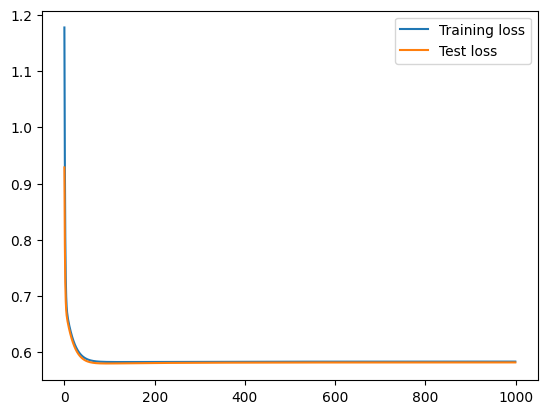

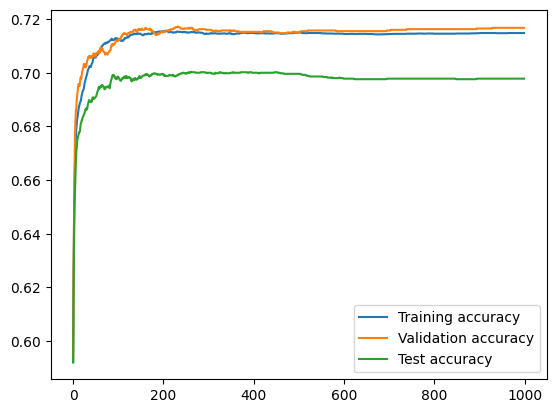

In [7]:
model = LogisticRegression(6, 1)
criterion = nn.BCELoss()  # Binary cross entropy
# Stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []
train_accs = []
test_accs = []
valid_accs = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()
    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()
    # Calculer la précision sur l'ensemble d'entraînement
    train_preds = model(X_train).round().detach().cpu().numpy()
    train_acc = (train_preds == y_train.detach().cpu().numpy()).mean()
    train_accs.append(train_acc)

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)
        valid_preds = model(X_valid).round().detach().cpu().numpy()
        valid_acc = (valid_preds == y_valid.detach().cpu().numpy()).mean()
        valid_accs.append(valid_acc)
    
    test_preds = model(X_test).round().detach().cpu().numpy()
    test_acc = (test_preds == y_test.detach().cpu().numpy()).mean()
    test_accs.append(test_acc)

plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()
plt.figure()
plt.plot(train_accs, label="Training accuracy")
plt.plot(valid_accs, label="Validation accuracy")
plt.plot(test_accs, label="Test accuracy")
plt.legend()
plt.show()

In [36]:
# Imprimer les précisions
print(f"Training accuracy: {train_accs[-1]:.3f}")
print(f"Validation accuracy: {valid_accs[-1]:.3f}")
print(f"Test accuracy: {test_accs[-1]:.3f}")

Training accuracy: 0.715
Validation accuracy: 0.717
Test accuracy: 0.698


Training accuracy: 0.715
Validation accuracy: 0.717
Test accuracy: 0.698

In [8]:
#print the weights of the model
weights = model.classifier[0].weight.detach().numpy()[0].round(4)
features = ['check_no', 'nb_pronouns', 'check_exclamation', 'log_nb_words', 'positive_count', 'negative_count']
print(weights)
print(features)

[-0.0299 -0.036  -0.0049 -0.0179  0.1306 -0.1545]
['check_no', 'nb_pronouns', 'check_exclamation', 'log_nb_words', 'positive_count', 'negative_count']


Ici nous pouvons que les poids du model sont respectivement: [-0.0299, -0.036, -0.0049, -0.0179,  0.1306, -0.1545]
Il faut regarder quel est la plus grosse valeur absolue pour savoir quel est la caracteristique la plus influente sur la prise de decision.
Ici la valeur absolue maximale est 0.1546 ce qui correspond au nombre de mots negatifs dans le commentaire.
On peut egalement remarquer que la deuxieme caracteristique la plus influente est le nombre de mots positifs avec un poids de 0.1306.
Le reste des caracteristiques est quasiment inutile dans la prise de decision.

In [19]:
wrong = 0
for i in range(len(X_test)):
    if test_preds[i][0] != y_test[i].item():
        print(train_dataset['text'][i])
        print(X_test[i])
        print("Expected: {}".format(y_test[i].item()))
        print("Got: {}".format(test_preds[i][0]))
        wrong += 1
        if wrong == 2:
            break

"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don't exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we're treated to the site of Vincent Gallo's throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, and the same cann

Dans les 2 cas notre classifier a predit une reponse negative a la place d'une reponse positive.
Cela est certainement du au fait que le nombre de mots negatifs est superier au nombre de mots positifs dans les deux commentaires car ce sont les caracteristiques qui pesent le plus sur la decision finale.
Pour resoudre ce genre de probleme il faudrait ajouter d'autre features pertinente pour rendre la prise de decison plus "heterogene" et donc eviter que ca ne soit que 2 poids qui influent sur la decision finale.